# Partie 1 - Exploration de données 
Import de données, feature engineering et analyse dans <a href="http://datascience.ibm.com">IBM Watson Studio</a> (ex DSX)

Cet exemple est basé sur le challenge Kaggle AdTracking disponible ici: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection
<br> Il s'agit de prédire la probabilité de conversion (colonne is_attributed) à partir d'un historique de clicks web (adresse IP, device, os, canal, type d'app, timestamp...)

Voir également:
<ul>
    <li><a href="https://github.com/obarrot/dsx/blob/master/AdTracking%20Data%20Modeling.ipynb">Partie 2</a> - Modélisation XGBoost et publication dans <a href="https://www.ibm.com/cloud/machine-learning">WatsonML</a>
    <li> Partie 3 - <a href="https://datadealerswmltester.mybluemix.net">Client web Py Flask</a> qui exploite le modèle déployé (API REST) et <a href="https://github.com/jfrieu/wmltester">code</a> associé    
    <li> Autres exemples sur <a href="https://github.com/obarrot/dsx">GitHub</a>
</ul>
<img src="http://biblioteca.uoc.edu/sites/default/files/IBM_Data%20Science.png">

# 1. Initialisation et lecture des données
### 1.1 Installation et import des libraries

On insère automatiquement les données d'authentification et les refs vers les fichiers du Cloud Object Storage via click sur Files > "insert to code"


In [1]:
#!pip install --user seaborn
import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# The code was removed by DSX for sharing.

### 1.2 Lecture et mise en forme du data set, 100000 lignes

In [3]:
columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8'
        }

In [4]:
#df.head()
df = pd.read_csv(body, usecols=columns, dtype=dtypes)
#df = pd.read_csv(body)

In [5]:

#df.set_index('ip')
df['click_time'] = pd.to_datetime(df['click_time'])
df['attributed_time'] = pd.to_datetime(df['attributed_time'])
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null uint32
app                100000 non-null uint16
device             100000 non-null uint16
os                 100000 non-null uint16
channel            100000 non-null uint16
click_time         100000 non-null datetime64[ns]
attributed_time    227 non-null datetime64[ns]
is_attributed      100000 non-null uint8
dtypes: datetime64[ns](2), uint16(4), uint32(1), uint8(1)
memory usage: 2.8 MB


# 2. 1ère analyse des données brutes

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


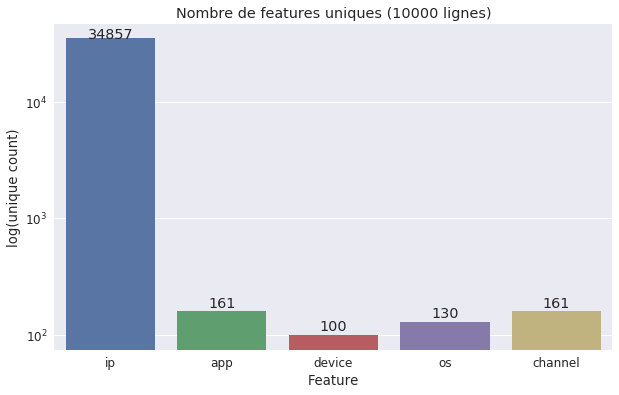

In [7]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Nombre de features uniques (10000 lignes)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

Il y a beaucoup plus d'IPs que d'apps, devices, os et channels

In [8]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


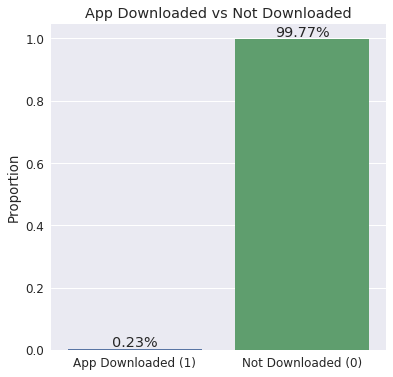

In [9]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (df.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

Le % d'attribution est très faible: uniquement 227 conversions sur un echantillon de 10000 clicks
<br> Il y a le même nombre de conversions que de timestamps donc les donnees de sortie ont l'air homogènes
<br> Les timestamp indiquent que les données sont sur 4j max

In [10]:
converted_timestamps = df.attributed_time.count() 
temp = df[df['is_attributed']==1]
print ("# of attributed lines: " , temp['is_attributed'].count())
print ("# of converted timestamps: " , converted_timestamps)
del temp

# of attributed lines:  227
# of converted timestamps:  227


# 3. Feature engineering

### 3.1 Création de nouvelles colonnes
<br> On va aggréger le nombre de clicks par IP et décomposer le timestamp du click en mois/jour/h afin de chercher des corrélations

In [11]:
ip_count = df.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
#ip_count.head()

df = pd.merge(df, ip_count, on='ip', how='left', sort=False)
#del ip_count
#gc.collect()
#df.head()

In [12]:
# Make some new features with click_time column
df['datetime'] = pd.to_datetime(df['click_time'])
#df['dow']      = df['datetime'].dt.dayofweek
df['doy']      = df['datetime'].dt.dayofyear
df['hod']      = df['datetime'].dt.hour
#df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day    
df.drop(['datetime'], axis=1, inplace=True)

In [13]:
#s1[s1['ip'] == 101424].head()
#del s1
gc.collect()
df.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,clicks_by_ip,doy,hod
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,8,311,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,149,311,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2,311,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,3,311,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,4,313,9
5,93663,3,1,17,115,2017-11-09 01:22:13,NaT,0,2,313,1
6,17059,1,1,17,135,2017-11-09 01:17:58,NaT,0,8,313,1
7,121505,9,1,25,442,2017-11-07 10:01:53,NaT,0,5,311,10
8,192967,2,2,22,364,2017-11-08 09:35:17,NaT,0,5,312,9
9,143636,3,1,19,135,2017-11-08 12:35:26,NaT,0,1,312,12


# 4. Analyse des corrélations entre variables
### 4.1 Corrélations entre les variables numériques

In [14]:
# filtrage des datas a corréler: numeric only
#cols = df[['ip','app','device','channel','doy','hod']].dtypes.index
cols = df.dtypes[df.dtypes!='datetime64[ns]'].index 
df_num = df[cols[:16]] 
#df_num.drop(['clicks_by_ip'],axis=1,inplace=True)
#df_num.info()

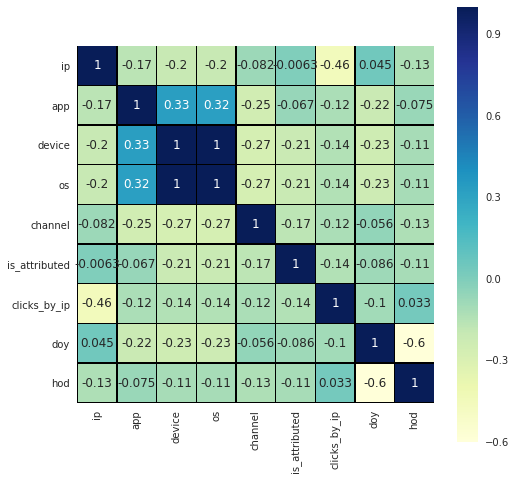

7071

In [15]:
# creation de la matrice de corrélation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1)
corr_mat=df_num.corr(method='pearson')
plt.figure(figsize=(8,8))

sns.heatmap(corr_mat.corr(),linewidths=0.25,vmax=1.0,\
            square=True, cmap="YlGnBu", linecolor='black', annot=True)
plt.show()
del df_num
gc.collect()

On observe des corrélations entre IP et nombre de clicks et entre jour et heure
<br>Dans une moindre mesure entre app, device et os

### 4.2 Analyse du # de clicks par IP

In [16]:
temp = df['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp.sort_values(by='counts',ascending=False)
temp.describe()
#temp.head()


,ip,counts
count,34857.000000,34857.000000
mean,117982.598990,2.868864
std,86470.801996,8.043182
min,9.000000,1.000000
25%,49418.000000,1.000000
50%,100054.000000,2.000000
75%,172689.000000,3.000000
max,364757.000000,669.000000


On a 34857 IPs différentes avec une moyenne de 2,86 clicks par IP et une distribution tres étalée: min 1x, max 669 clicks pour 1 IP

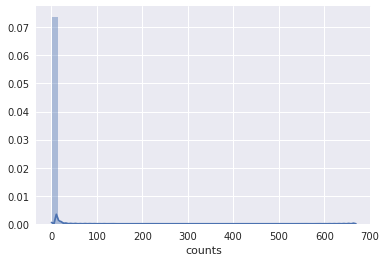

In [17]:
import seaborn as sns
sns.distplot(temp['counts'])
plt.show()

Il y a certainement des robots dans les 20 premières IPs classées par # de hits

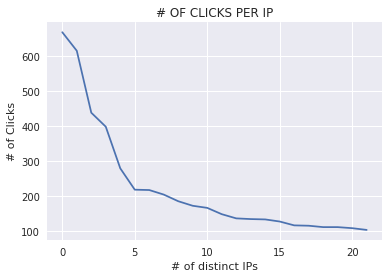

In [18]:
temp=temp[temp['counts']>100]
ax = temp['counts'].plot()
ax.set_title('# OF CLICKS PER IP')
ax.set_xlabel('# of distinct IPs')
ax.set_ylabel('# of Clicks');

In [19]:
del temp
gc.collect()

5318

# 5. Analyse des conversions
<br> Ici on va s'intéresser uniquement aux clicks qui ont converti

In [20]:
# on ne retient que les IP qui ont converti
attributed = df[df['is_attributed']==1]
attributed.drop(['doy','hod','clicks_by_ip','is_attributed'],axis=1,inplace=True)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Feature engineering: on calcule le délai de conversion cad le délai entre le click et l'attribution

In [21]:
attributed ['attributed_delay'] = attributed ['attributed_time'] - attributed ['click_time']
attributed['attributed_delay_hh']=attributed['attributed_delay'].astype('timedelta64[h]')
attributed.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,ip,app,device,os,channel,click_time,attributed_time,attributed_delay,attributed_delay_hh
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,00:00:25,0.0
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,00:00:32,0.0
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,02:04:43,2.0
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,00:53:15,0.0
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,03:35:59,3.0


In [22]:
attributed['attributed_delay'].describe()
attributed.drop(['attributed_delay'],axis=1,inplace=True)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### 5.1 Analyse des corrélations sur les clicks convertis

In [23]:
# filtrage des datas a corréler: numeric only
cols = attributed.dtypes[attributed.dtypes!='datetime64[ns]'].index 
df_num = attributed[cols[:16]] 
#df_num.head()

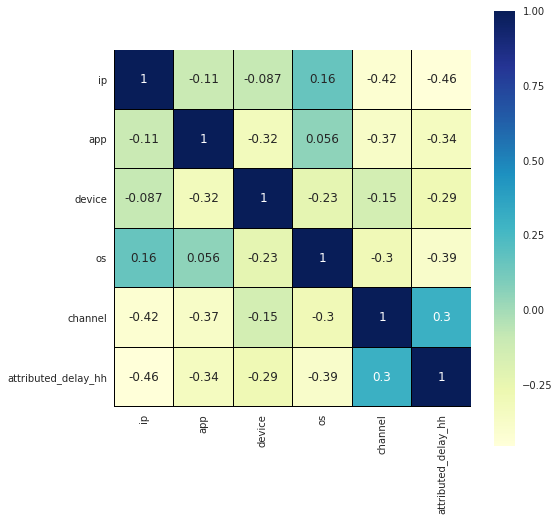

In [24]:
# creation de la matrice de corrélation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1)
corr_mat=df_num.corr(method='pearson')
plt.figure(figsize=(8,8))

sns.heatmap(corr_mat.corr(),linewidths=0.25,vmax=1.0,\
            square=True, cmap="YlGnBu", linecolor='black', annot=True)
plt.show()
del df_num

On note une corrélation entre delai de conversion, ip et canal

### 5.2 Analyse du délai de conversion 

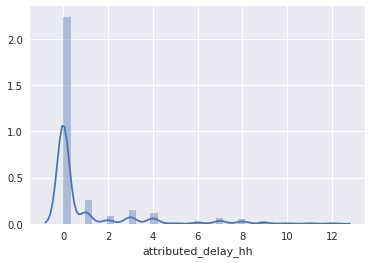

In [25]:
sns.distplot(attributed['attributed_delay_hh'])
#attributed.drop(['attributed_delay_hh'], axis=1, inplace=True)

Le délai de conversion est entre 2s et 13h avec une moyenne à 1h15

### 5.3 Analyse des conversions par heure

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5,0,'Hour of day')

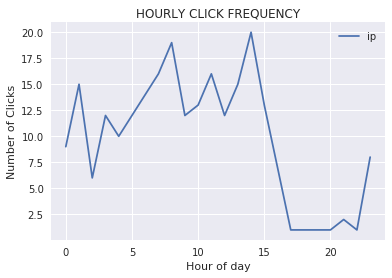

In [26]:
attributed['attributed_hod'] = attributed['attributed_time'].dt.hour
attributed[['ip','attributed_hod']].groupby(['attributed_hod'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');
plt.xlabel('Hour of day')

On remarque un creux en fin d'après-midi